# Answers

You can edit this Jupyter notebook to include your answers and run any code that generates those answers or produces plots.  You can add additional cells for code or markdown as needed.

This homework is primarily about running simulations involving initial value problems (IVPs) and a simple PDE.

In [ ]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
from scipy.integrate import DenseOutput
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.sparse as sparse
from sympy import Function, dsolve, Eq, Derivative, sin, cos, symbols
from scipy.integrate import solve_ivp
import importlib

## Problem 0 (30 points)

In this problem, you will implement a custom ODE solver for `solve_ivp` based on the Forward Euler method, and implement some basic tests.

### Part A (20 points)
If you read the [documentation for `solve_ipv`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html), which we used in class, you'll see that you can write your own solver.

Write a solver for the forward Euler method, which is not implemented as one of the available solvers (while simple, it typically is not very accurate).  Recall, this is the basic rule:
\begin{equation}
y(t + h) = y(t) + h f(t, y)
\end{equation}

Your solver should be a class which is derived from [`scipy.integrate.OdeSolver`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.OdeSolver.html#scipy.integrate.OdeSolver)
```python
class ForwardEuler(scipy.integrate.OdeSolver):
    pass
```

Your class definition should go in [`euler.py`](euler.py)

You should read the documentation for this base class in order to implement `ForwardEuler`.  Here are some hints/notes:
* Allow a user to set `h` using a keyword argument.  This can be passed using `solve_ivp(..., method=ForwardEuler, h=0.01)` to set `h=0.01`
* Use a default step size `h = (t_bound - t0) / 100`
* private methods begin with an underscore "_"
* the method `_dense_output_impl(self)` should output a `ForwardEulerOutput` (defined in [`euler.py`](euler.py))
* direction should be `+1`
* You won't use a Jacobian, so `njev` and `nlu` can remain at 0.
* You may want to consider using `super(ForwardEuler, self).__init__`
* You may want to read the source code for the parent class [here](https://github.com/scipy/scipy/blob/v1.5.3/scipy/integrate/_ivp/base.py#L25-L214)

---

*put any discussion here*

In [3]:
from euler import ForwardEuler
from sympy.abc import x # x is overwritten in previous cells so we need to import here

### Part B (10 points)

Use your `ForwardEuler` solver and `solve_ivp` to solve an IVP $y'(t) = y$ with $y(0) = 1$ on the domain $t\in [0,5]$, using a step size `h=0.01`.  Make a plot of the solution to this IVP with axes labeled `y` and `x`.

Use SymPy to obtain the ground-truth solution to this IVP.  What is the largest error you see on the domain you solved the problem?  Try solving with the default solver in `solve_ivp`.  What is the largest error in this case?

---

*put your answers here*

In [24]:
def fun1(t,y): # Define the function y'(t) = f(t,y) = y
    return y

sol = solve_ivp(fun1, 
                t_span=[0,5],
                y0 = [1],
                method = ForwardEuler,
                h = 0.01)

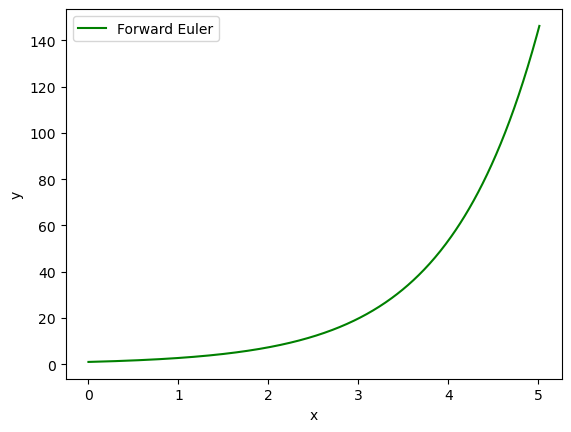

In [25]:
plt.plot(sol.t, sol.y[-1], color = 'green', label = 'Forward Euler')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
# Use Sympy to find the real solution
t = symbols('t')
y = Function('y')
eqn = y(t).diff(t) - y(t) # put them in same side then make it equal to 0
eqn 

-y(t) + Derivative(y(t), t)

In [16]:
# We know it is separable, so directly use .dsove()
dsolve(eqn, hint='separable', ics={y(0):1}) # Set initial value y(0) = 1

Eq(y(t), exp(t))

So the solution $y(t)$ is actually $y(t) = e^{t}$.

In [48]:
# Find the largest error
y = np.exp(sol.t) # generate the exact y(t) on the same time span t in [0, 5] with h = 0.01
error1 = np.abs(y-sol.y[-1])
print('The largest error is:', np.max(error1))
print('It occurs when t =', np.round(sol.t[np.where(error1 == np.max(error1))][0]))


The largest error is: 3.6842359921385537
It occurs when t = 5.0


In [53]:
# Try the defualt method Explicit Runge-Kutta method of order 5(4)
sol_rk45 = solve_ivp(fun1, 
                t_span=[0,5],
                y0 = [1],
                max_step = 0.01)

In [55]:
error2 = np.abs(y - sol_rk45.y[-1])
print('The largest error is:', np.max(error2))
print('It occurs when t =', np.round(sol_rk45.t[np.where(error2 == np.max(error2))][0]))

The largest error is: 1.4915770464402272
It occurs when t = 5.0


It looks like both two largest errors occur at the end of time bound(maybe due to accumulation of error in each step). But Runge-Kutta method of order 5(4) is more precise than Forward Euler.

### Part C (optional challenge)

Use Richardson (see Problem 0) on your Forward Euler solver. How does the error change? You can assume that $m=1$ and derive the formula analytically. What happens if you do Richardson twice?

In [ ]:
# I did not see the Richardson......

## Problem 1 (20 points)

Now that you're warmed up, here are some more simulations.

### Part A (15 points)

In this problem, we'll simulate a planet and moon moving in a 2-dimensional plane.

Newton's law of gravity says that $F_g = Gm_1 m_2 / \|r\|^2$.  The direction of the force is in the direction of the vector $r$.  Let $x(t)$ dentote the position of the planet and $y(t)$ denote the position of the moon, and $r(t) = x(t) - y(t)$ Then
\begin{equation}
x''(t) = -F_g / m_1 \times r / \|r\| \\
\end{equation}

\begin{equation}
y''(t) = F_g / m_2 \times r / \|r\|
\end{equation}
$x$ and $y$ are 2-vectors, so this is a system of 4-second order ODEs.  We can use the following trick to write this as 8 first order ODEs. Let $p(t)$ be the velocity of the planet and $q(t)$ be the velocity of the moon (note that they are vector valued!). So, $p(t) = x'(t)$, and $q(t) = y'(t)$. \
Here are the terms for $x$:
\begin{equation}
p_1'(t) = -F_g / m_1 \times r_1(t) / \|r\| \\
p_2'(t) = -F_g / m_1 \times r_2(t) / \|r\| \\
x_1'(t) = p_1(t) \\
x_2'(t) = p_2(t)
\end{equation}

\begin{equation}
q_1'(t) = F_g / m_2 \times r_1(t) / \|r\| \\
q_2'(t) = F_g / m_2 \times r_2(t) / \|r\| \\
y_1'(t) = q_1(t) \\
y_2'(t) = q_2(t)
\end{equation}

We'll model the Earth and moon.  The [Gravitational constant](https://en.wikipedia.org/wiki/Gravitational_constant) has value `G=6.67 e-11` (we're dropping units, which are all SI).  The mass of the earth is `m1 = 5.972 e24`, and the mass of the moon is `m2=0.07346 e24`.  The distance from the moon to the earth is `r = 384.4 e6`.  This means the orbital speed of the moon around the earth is about `1.022 e3`.

Use `solve_ivp` to run a simulation of the moon orbiting the earth for `5 e6` seconds (about 2 months).  Use initial conditions $x(0) = 0, p(0) = 0$ for the earth, and $y(0) = (0, 384.4 \times 10^6)$ and $q(0) = (1.022 \times 10^3, 0)$

Plot $x_1(t), x_2(t)$ and $y_1(t), y_2(t)$ in the same plane with different colors (include a legend and title).

---

*Put any answers/discussion here*

In [76]:
# Define the constant
G = 6.67e-11 # Gravatational Constant
m1 = 5.972e24 # mass of earth
m2 = 0.07346e24 # mass of moon

# Define the Initial State
Y0 = np.array([
    0, #x0 = 0
    0,
    0, #y0 = (0,s84.4e6)
    384.4e6,
    0, #p0 = 0
    0,
    1.022e3, # q0 = (1.022e3, 0)
    0
])

# x(t), y(t) denotes the position of earth and moon
# p(t), q(t) denotes velovity of earth and moon
# The logic is that we want to model the earth and moon, 
# so the function should return a 'set' of (x(t), y(t), p(t), q(t))
# They are 2-D vectors so can be decomposed as (x1(t), x2(t), y1(t), y2(t), p1(t), p2(t), q1(t), q2(t))
# For these 8 functions, we can tranfer all them into Initial Value Problem
# e.g x'(t) = p1(t), which is an IVP with IV = 0
# Solve_IVP can process vector we can combine them into a vector then put into SolveIVP to get solution.


def earth_moon_model(t, Y): # Y denotes the current model of earth and moon, t denotes the time
    # First, we should obtain previous x,y,p,q
    x1, x2, y1, y2, p1, p2, q1, q2 = Y
    # Then, return the new x,y,p,q depending on 8 first order ODE
    # for p and q, there exist F_g/m_1 or F_g/m_2 = Gm_2/||r||^2, Gm_1/||r||^2
    # e.g. p1'(t) = (-F_g/m_1)*(r_1(t)/||r||)
    #             = -(Gm_2r_1(t))/||r||^3
    # here, r = x-y = (x1-y1, x2-y2), r1 = x1 - y1

    return np.array([
        p1, # x1'(t) = p1(t)
        p2, # x2'(t) = p2(t)
        q1, # y1'(t) = q1(t)
        q2, # y2'(t) = q2(2)
        # p1'(t) = -(Gm_2r_1(t))/||r||^3
        np.divide((-G*m2)*(x1 - y1), np.power(np.linalg.norm(np.array([x1-y1, x2-y2])), 3)),
        # p2'(t) = -(Gm_2r_2(t))/||r||^3
        np.divide((-G*m2)*(x2 - y2), np.power(np.linalg.norm(np.array([x1-y1, x2-y2])), 3)),
        # q1'(t) = (Gm_1r_1(t))/||r||^3
        np.divide((G*m1)*(x1 - y1), np.power(np.linalg.norm(np.array([x1-y1, x2-y2])), 3)),
        # q2'(t) = (Gm_1r_2(t))/||r||^3
        np.divide((G*m1)*(x2 - y2), np.power(np.linalg.norm(np.array([x1-y1, x2-y2])), 3)),
    ])


In [87]:
# Now, apply solve_ivp to solve it
sol = solve_ivp(fun=earth_moon_model,
                t_span=[0, 5e6],
                y0=Y0,
                max_step = 100
                )

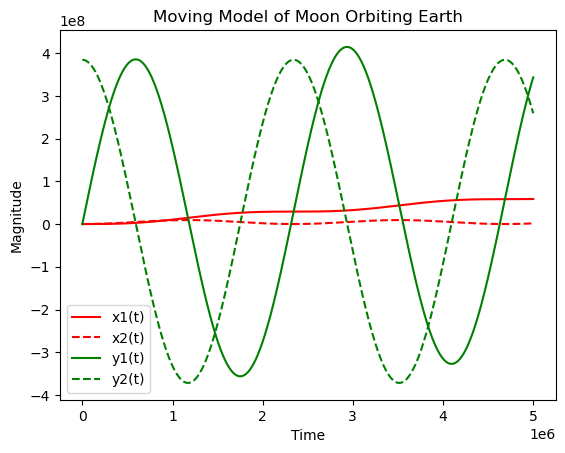

In [147]:
# We wanna plot x_1(t), x_2(t), y_1(t), y_2(t)
plt.plot(sol.t, sol.y[0], label = 'x1(t)', color = 'red')
plt.plot(sol.t, sol.y[1], label = 'x2(t)', color = 'red', ls = '--')
plt.plot(sol.t, sol.y[2], label = 'y1(t)', color = 'green')
plt.plot(sol.t, sol.y[3], label = 'y2(t)', color = 'green', ls = '--')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Moving Model of Moon Orbiting Earth')
plt.legend()
plt.show()

### Part B (5 points)

Now simulate a system with 10 planets, in 10 random locations. The planets should have random masses chosen independently and uniformly from the interval $[0,6 \times 10^{24}]$ and initial locations chosen randomly from the $(8 \times 10^8) \times (8\times 10^8)$ square centered at the origin. The components of each planet's initial velocity should be chosen randomly on $[-5\times 10^{2}, 5 \times 10^{2}].$ Plot the positions of each planet as a function of time.

---

*Your answer here.  You can create some code cells as well*

The difference is that for example, for planet i, its $p_1, p_2$ changes to: \\
\begin{align*}
p_1(t) &= \sum_{j=0, j \neq i}^9 -Gm_j \frac{x_{i1} - y_{j1}}{\lVert x_i - y_j \rVert^3}
\end{align*}

Here, $x_{i1}$ means $x_1$ of planet i and $y_1$ of planet j.

In [177]:
# Randomly generate the mass, initial location, and intial velocity of each 10 planet.
mass = np.random.uniform(0,6e24,10)
ini_loc = np.random.uniform(-4e8, 4e8, (10,2)) # a 8e8*8e8 squared means from -4e8 to 4e8 for both x and y axies
ini_vel = np.random.uniform(-5e2, 5e2, (10,2))

In [192]:
# In order to use solve_IVP, we must return a Y containing all the components of all the planets
# First, define the initial value

Y0 = np.concat((ini_loc.flatten(), ini_vel.flatten())) # Use .flatten() to change ini_loc, ini_vel into 1-D array
                                                       # Then store it as initial value

def planet_loc(t, Y):
    Loc = Y[:20].reshape((10,2)) # Here, I revert the initial value Y0 back into two 10*2 array to represent location and velovity of 
                                 # each planet.
    updated_loc = Y[20:] # we know that each x_1', x_2' = p1, p2
    
    updated_Vel = np.zeros((10,2)) # initial a 10*2 array to store the updated velocity

    for i in range(10):
        for j in range(10):
            if i != j: # make all the combination of 10 planets except it with itself!
                # for distance r, we need 3 types of r
                r_ij = Loc[i] - Loc[j] # it's a vector r = x - y
                r_ij_1 = Loc[i][0] - Loc[j][0] # it's a float r1 = x1-y1
                r_ij_2 = Loc[i][1] - Loc[j][1] # it's a float r2 = x2-y2
                # Now we can define new p_1' and p_2'
                updated_Vel[i][0] += np.divide((-G*mass[j]*r_ij_1),np.power(np.linalg.norm(r_ij),3))
                updated_Vel[i][1] += np.divide((-G*mass[j]*r_ij_2),np.power(np.linalg.norm(r_ij),3))
        # when this loop end, we actually get the sum of it with planet i to any other planet j
    # Finally, flatten it and contac them together to be returned
    return np.concatenate((updated_loc, updated_Vel.flatten()))    


In [193]:
# Now, apply the solve_ivp
sol2 = solve_ivp(fun=planet_loc,
                 t_span=[0,5e6],
                 y0=Y0,
                 max_step=1e3
                 )

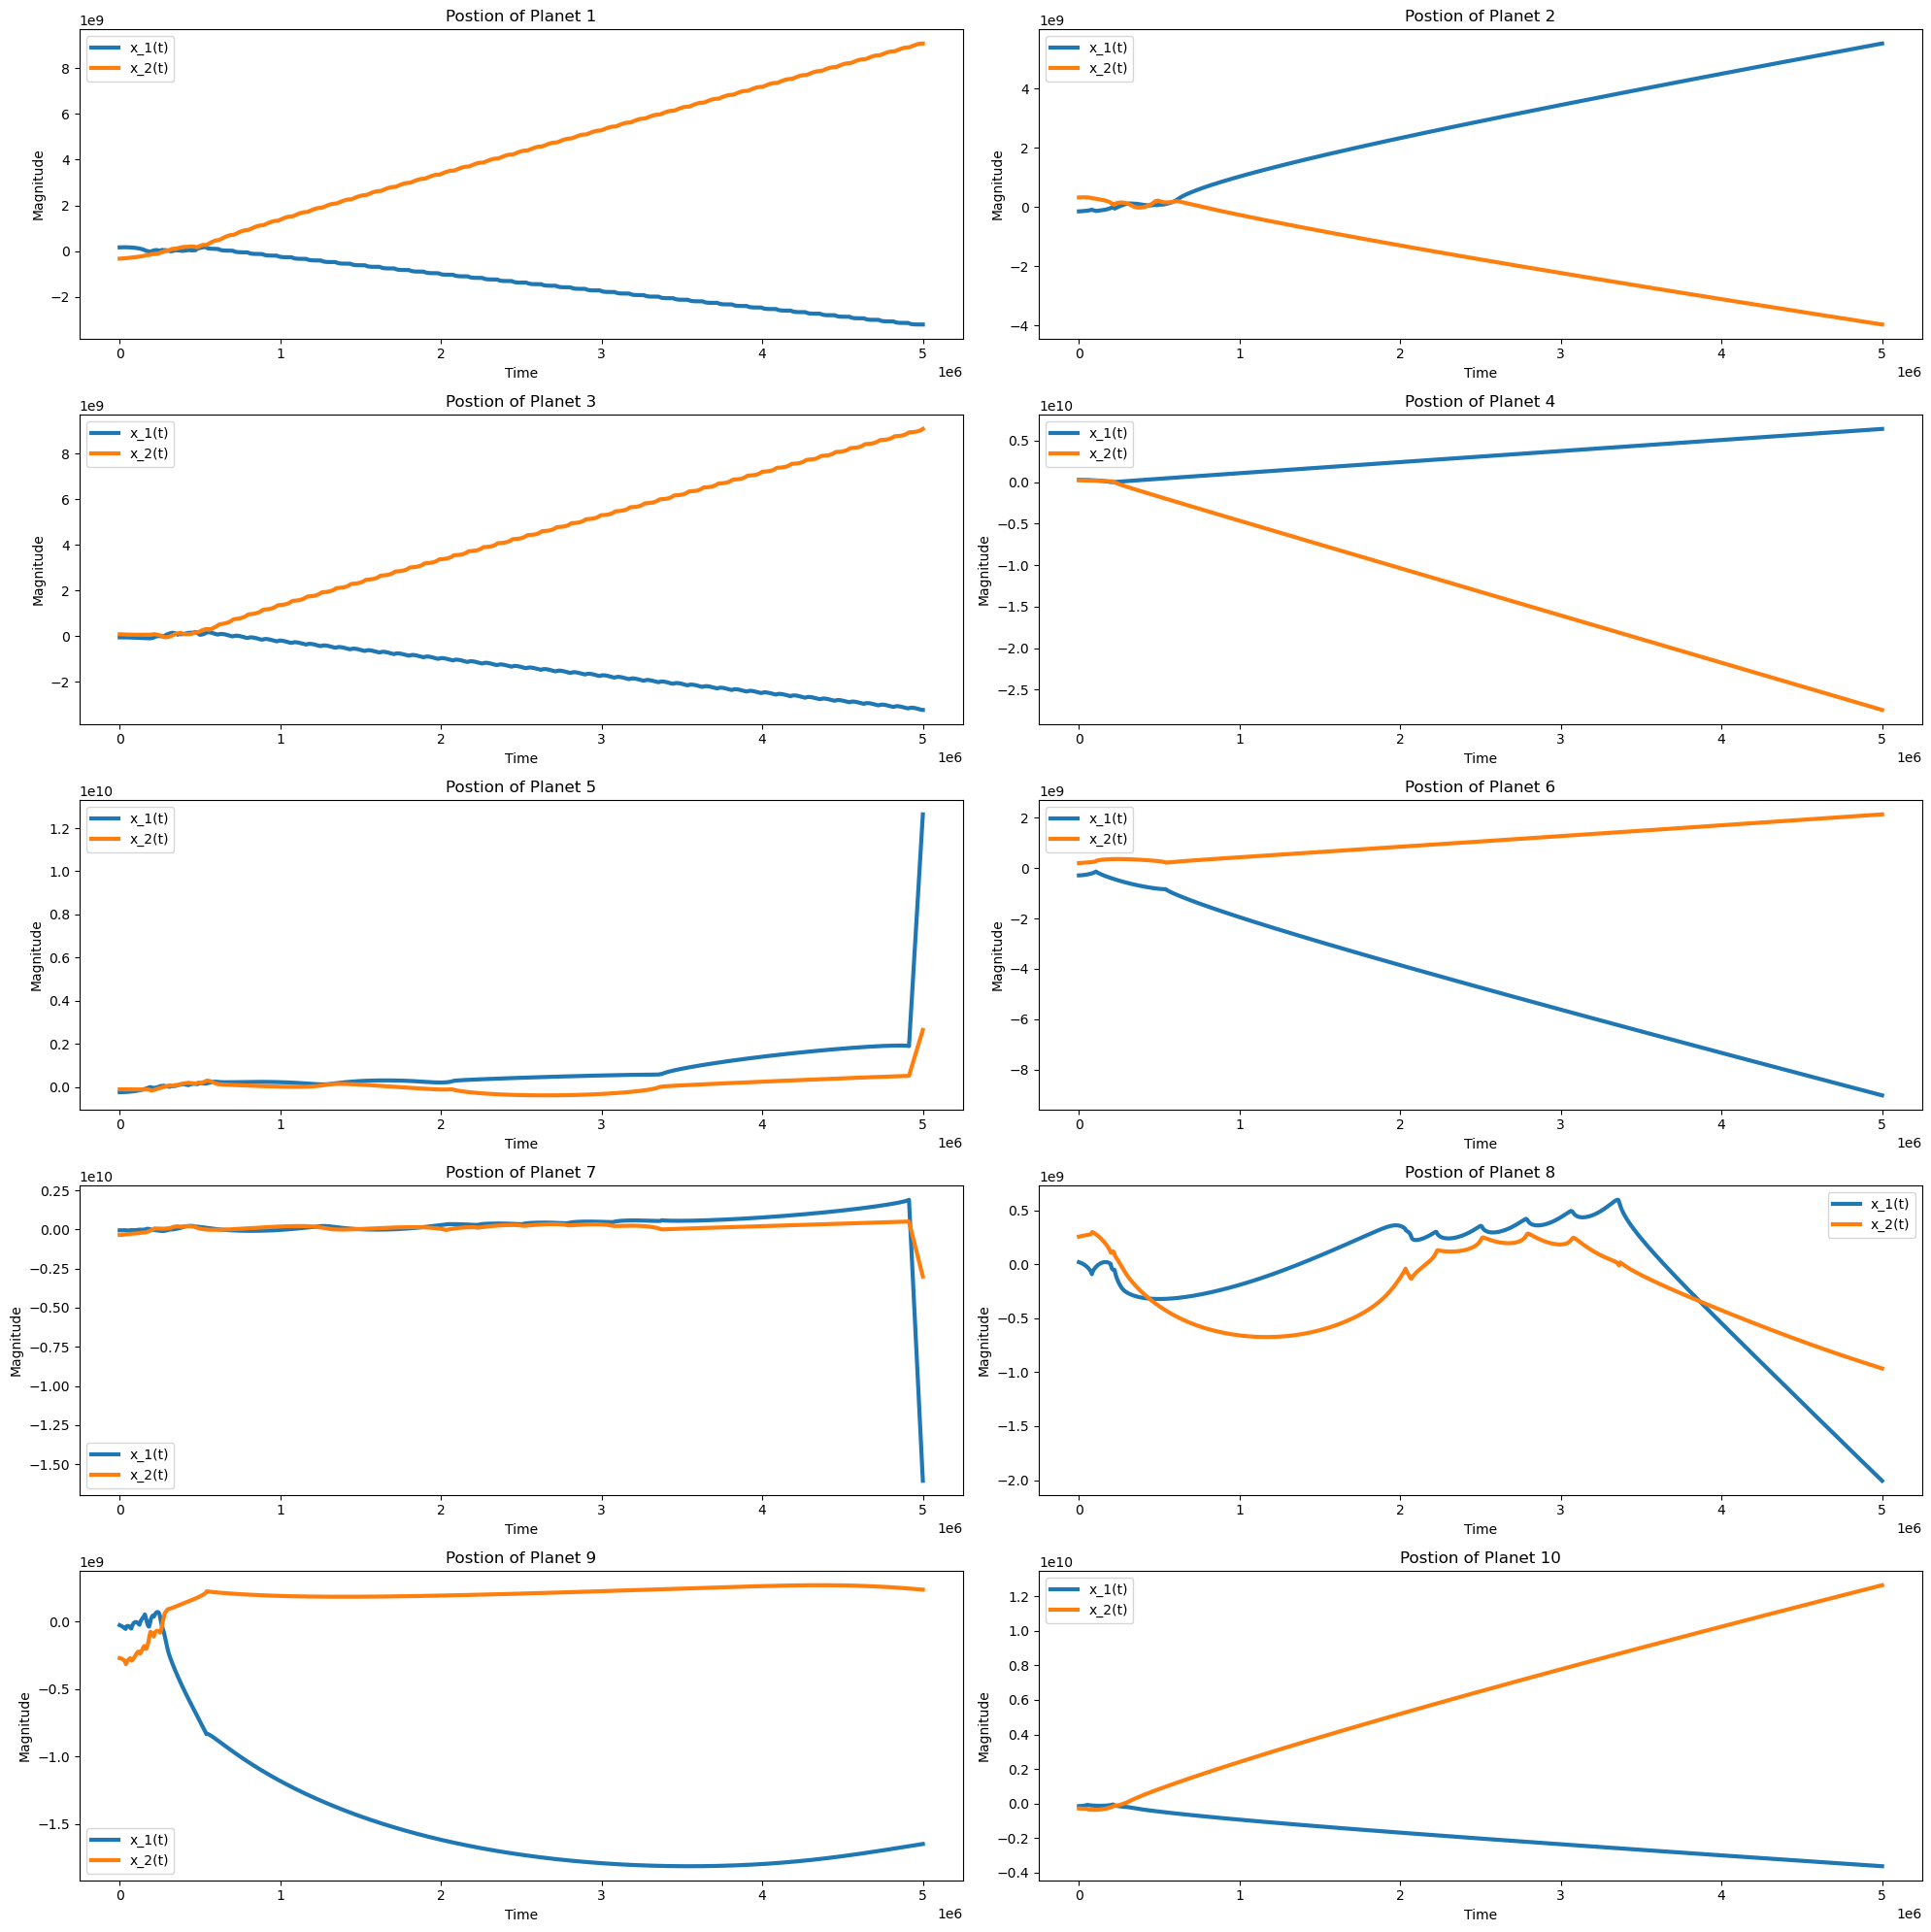

[0.00000000e+00 6.58325800e-01 7.24158380e+00 ... 4.99879317e+06
 4.99979317e+06 5.00000000e+06]


In [194]:
# Use loop to plot!
m, n = 5, 2
fig, ax = plt.subplots(m,n,figsize=(20,20))
count =1 
for i in range(m):       # 0 1 2 3; 4, 5, 6, 7
    for j in range(n):
        ax[i,j].plot(sol2.t, sol2.y[4*i+2*j], label = 'x_1(t)', lw=3)
        ax[i,j].plot(sol2.t, sol2.y[4*i+2*j+1], label = 'x_2(t)', lw=3)
        ax[i,j].legend()
        ax[i,j].set_title(f'Postion of Planet {count}')
        count += 1
        ax[i,j].set_xlabel('Time')
        ax[i,j].set_ylabel('Magnitude')
plt.tight_layout()
plt.show()
print(sol2.t)


In [185]:
a = np.array([[1,2],[3,4]])
a[0][0] = 5
print(a)

[[5 2]
 [3 4]]


## Problem 2 (30 points)
In this problem, we will solve some a simple PDE using the "method of lines". In this method, we replace the
$$\partial_t u(t,x) = \Delta u(t,x) $$
PDE by the system of ODEs
$$ \partial_t\boldsymbol{u}(t) = A \boldsymbol{u}(t),$$
where
$$[\boldsymbol{u}(t)]_i=u_i(t) \approx u(t,x_i). $$
The matrix $A$ approximates the differential operator using, e.g. finite differences
$$ \Delta u \to A \boldsymbol{u}.$$

After we semi-discretize in space we are left with a large system of ODEs that we can solve using our favorite method.
 

### Part A (25 points)
In this problem we will solve the heat equation 
\begin{equation}
\begin{cases}
\partial_t u(t,x) = \Delta u(t,x) & x\in [0,1], \;t\in[0,T]\\
u(0,x) = f(x) & x\in [0,1]\\
u(t,0) = a & t \in [0,T]\\
u(t,1) = b & t \in [0,T]\\
\end{cases}
\end{equation}
with the method of lines.

To solve this equation, we discretize the interval $x\in[0,1]$ with $n+2$ points. The end points will be used to enforce boundary conditions and the interior points will be used to compute the right hand side of the PDE. We approximate the Laplacian operator using the second order centered difference formula
$$g''(x) = \frac{g(x+h)-2g(x)+g(x-h)}{h^2}$$
and we integrate in time using the forward Euler method.

Your code for implementing this method should include the following three functions
1. `second_diff`, which computes the second derivative of $u$ at the interior nodes (using the centered difference formula) and returns it as an array with zeros on each end (as the boundary conditions don't change)
2. `forward_time_step`, which uses $u(t_n,x)$ and the forward Euler method to compute $u(t_{n+1},x)$
3. `sim_heat`, which solves the heat equation by setting $u(0,x)=f(x)$ and then calling `forward_time_step` repeatedly to compute $u(T,x)$. This function should accept the following inputes
    * `n` the number of internal nodes 
    * `f` the initial condition
    * `bc` a list containing the left and right boundary conditions $a$ and $b$
    * `dx` the grid spacing, i.e. the distance between x values i.e. $1/(n+1)$
    * `dt` the time step to be used by the forward Euler method
    * `T` the time at which we want the solution $u(T,x)$. Note that in general $T/dt$ will not be an integer, so the last call of `forward_time_step` will have to use a smaller time step than `dt`

Once you have created these functions, solve the heat equation with
\begin{gather}
f(x) = \sin(2\pi x)\\
a = b = 0
\end{gather}
up until time $T=0.02$ using $n=99$ and `dt=0.2*dx**2`. 

To verify the accuracy of your code, compare the output to the exact solution $u(t,x)= \exp(-4\pi^2t)\sin(2\pi x)$. You can do this by summing the sum of squares errors at your $x_i$'s and dividing by $\sqrt{n}$.

You should also include a plot of $u(0,x)$ and $u(T,x)$.

In [208]:
# dx is float indiating the step size of of x
# Here, u should be an array containing each u(t,x_i)
# x \in [0,1], so the two end elment of u should be u(t,0) = a and u(t,1) = b
# dx is the grid spacing of x, indicating h I think
# the length of u should be n+2 because we divide interval x into n+2 points
def second_diff(u,dx):
    outcome = [0] # 0 on the left end
    for i in range(1, len(u)-1):
        outcome.append(np.divide((u[i+1] - 2*u[i] + u[i-1]),np.power(dx,2))) # do the centeref difference formula
    outcome.append(0) # 0 on the right end
    return outcome

def forward_time_step(u,dx,dt):
    # Here, we do one-step the Forward Euler Method for every u(t,x_i)
    f = second_diff(u, dx)
    u += dt*np.array(f) # u and f are same-demension arrays
    return u

def sim_heat(n,f,bc,dx,dt,T):
    # first, define the u, which now is actually the initial value
    u = f(np.linspace(0,1,num=n+2)) # x \in [0,1] and we actually need n+2 points 
    u[0] = bc[0]
    u[-1] = bc[-1]
    if u[0] != bc[0] or u[-1] != bc[-1]:
        raise ValueError # Check boundary
    u = np.array(u)
    # Sometimes u[-1] != bc[-1], so we should make it equal anyway

    # We need record time to ensure T in the correct time span
    time = 0 
    while time <= 1: # Not over the boundary
        if (time <= T) and (T <= time + dt): # when time goes to a case that time <= Y <= time + dt
                                             # We should do a small Euler Forward to get values at T
            u = forward_time_step(u,dx,T-time)
            return u
        u = forward_time_step(u, dx, dt)
        time += dt
    print('Time reaches Limit!!')
    return u


In [204]:
# Define f and other parameters
f = lambda x: np.sin(2*np.pi*x)
bc = [0,0]
T = 0.02
n = 99
dx = np.divide(1, n+1)
dt =0.2*dx**2

In [214]:
sol_u = sim_heat(n,f,bc,dx,dt,T)

In [216]:
t_span = np.linspace(0,1,101)
true_sol_u = np.exp(-4*(np.pi**2)*T)*np.sin(2*np.pi*t_span) 
print('The error is:', np.sum(np.power(true_sol_u-sol_u,2))/np.sqrt(n))


The error is: 2.7951267820883405e-09


It indicates it is a good estimator!

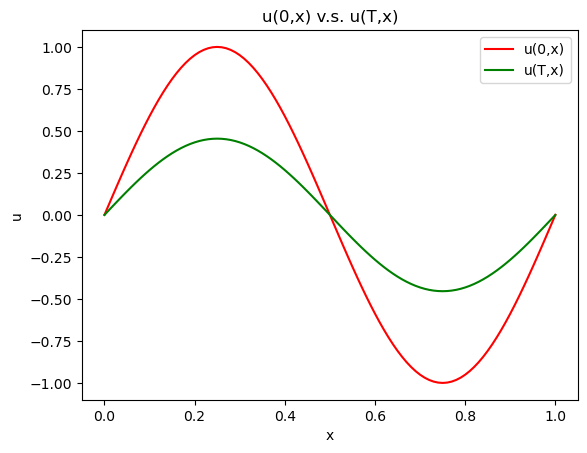

In [220]:
# Plot of u(0,x) and u(T,x)
plt.plot(t_span, sim_heat(n,f,bc,dx,dt,0), color = 'red', label = 'u(0,x)')
plt.plot(t_span, sim_heat(n,f,bc,dx,dt,T), color = 'green', label = 'u(T,x)')
plt.legend()
plt.xlabel('x')
plt.ylabel('u')
plt.title('u(0,x) v.s. u(T,x)')
plt.show()


## Part B (5 points)
Now solve for $u(T,x)$ using the same parameters as above, except that you should set `dt=0.7*dx**2`. Create a plot of $u(0,x)$ and $u(T,x)$ and compare it to the plot from the previous question. The ratio $dt/dx^2$ is called the CFL (Courant–Friedrichs–Lewy) number and the observation that you will make is an important concept in numerical PDE methods.

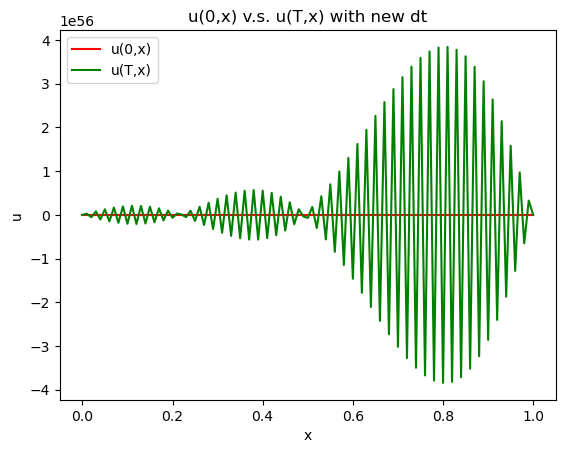

In [223]:
# New dt
dt_new = 0.7*dx**2

plt.plot(t_span, sim_heat(n,f,bc,dx,dt_new,0), color = 'red', label = 'u(0,x)')
plt.plot(t_span, sim_heat(n,f,bc,dx,dt_new,T), color = 'green', label = 'u(T,x)')
plt.legend()
plt.xlabel('x')
plt.ylabel('u')
plt.title('u(0,x) v.s. u(T,x) with new dt')
plt.show()


Compared two graphs, $u(T,x)$ changed to a sharp wave and $u(0,t)$ becomes nearly a line! 

In [225]:
print('The old ratio dt/dx^2 is', np.divide(dt, np.power(dx,2)))
print('The new ratio dt/dx^2 is', np.divide(dt_new, np.power(dx,2)))

The old ratio dt/dx^2 is 0.2
The new ratio dt/dx^2 is 0.7


## Part C (optional, 5 bonus points)
The CFL condition that $dt/dx^2<0.5$ is prohibitively restrictive. To get around this, we can use so-called implicit time stepping schemes, which are far more stable, though computationally costly. The simplest of these schemes is the backwards Euler method:
$$ y(t_{n+1}) = y(t_n) + dt y'(t_{n+1})$$
(Note that $y'$ is now evaluated at a future time.) When solving a linear system of ODEs
$$ y'= A y$$
the backwards Euler method requires us to solve the linear system
$$ (I - dt A)y(t_{n+1}) = y(t_{n}). $$

In this problem you should modify your existing code to solve the heat equation using this implicit time stepping scheme. In order to do this efficiently, you should construct and store a Cholesky factorization of the matrix $I-dt A$.

With this new code, repeat the experiment from part B. Do you run into the same stability problem?

Further, with this method, are you able to make $dt$ a comparable size to $dx$?

## Feedback

If you would like share how long it took you to complete this assignment, it will help adjust the difficulty for future assignments.  You're welcome to share additional feedback as well.